CDAE Simulation #2: Simple Math
=================

Implementation of CDAE using elementary floating point operations and hand-written functions instead of `scipy.signal`. Loads reference data from `cdae_dbg_*` (generated by [cdae_demo.ipynb](cdae_demo.ipynb)) and compares with the float point results generated by this implementation.

In [1]:
%pylab inline --no-import-all

oversampling = 8

fir_h = None
iir_sos = []

with open("cdae_dbg_config.txt", "r") as f:
    for line in f:
        line = line.split()
        if len(line) > 0 and line[0] == "fir_h":
            fir_h = [float(v) for v in line[1:]]
        if len(line) > 0 and line[0] == "iir_sos":
            iir_sos.append([float(v) for v in line[1:]])

fir_h = np.array(fir_h)
iir_sos = np.array(iir_sos)

REF_INPUT_SAMPLES    = np.loadtxt("cdae_dbg_samples.txt")
REF_INTERP_SAMPLES   = np.loadtxt("cdae_dbg_resampled.txt")
REF_FILTERED_SAMPLES = np.loadtxt("cdae_dbg_filtered.txt")
REF_RESULTS          = np.loadtxt("cdae_dbg_results.txt")

M = REF_INTERP_SAMPLES.shape[0]
N = REF_INTERP_SAMPLES.shape[1]

Populating the interactive namespace from numpy and matplotlib


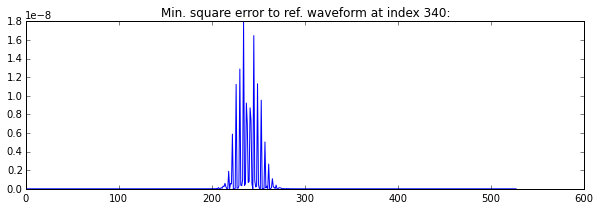

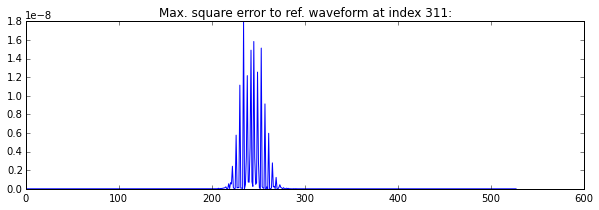

In [2]:
def my_polyphase_fir_filter(isamples):
    isamples = np.copy(isamples) - isamples[0]
    osamples = np.zeros(len(isamples)*oversampling)
    fstate = np.zeros(len(fir_h))
    for i in range(len(osamples)):
        fstate = np.roll(fstate, 1)
        fstate[0] = isamples[i//oversampling] if i%oversampling == 0 else 0
        osamples[i] = fstate.dot(fir_h)
    return np.roll(osamples, -len(fir_h)//2)

max_sqerr = None
max_sqerr_idx = None

min_sqerr = None
min_sqerr_idx = None

interp_out = np.zeros((M, N))
for i in range(M):
    interp_out[i,:] = my_polyphase_fir_filter(REF_INPUT_SAMPLES[i,:])
    sqerr = interp_out[i,:] - REF_INTERP_SAMPLES[i,:]
    sqerr = sqerr.dot(sqerr)
    
    if max_sqerr is None or sqerr > max_sqerr:
        max_sqerr = sqerr
        max_sqerr_idx = i

    if min_sqerr is None or sqerr < min_sqerr:
        min_sqerr = sqerr
        min_sqerr_idx = i

plt.figure(figsize=(10, 3))
plt.title("Min. square error to ref. waveform at index %d:" % min_sqerr_idx)
plt.plot((interp_out[min_sqerr_idx,:] - REF_INTERP_SAMPLES[min_sqerr_idx,:]) ** 2)

plt.figure(figsize=(10, 3))
plt.title("Max. square error to ref. waveform at index %d:" % max_sqerr_idx)
plt.plot((interp_out[max_sqerr_idx,:] - REF_INTERP_SAMPLES[max_sqerr_idx,:]) ** 2);

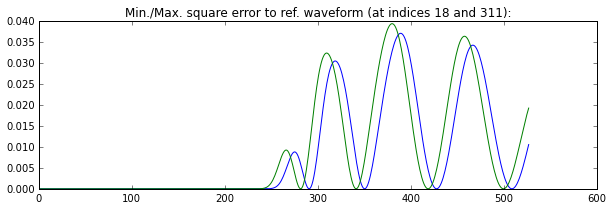

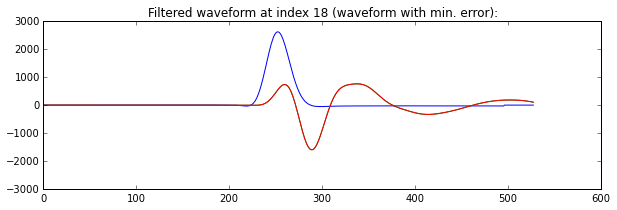

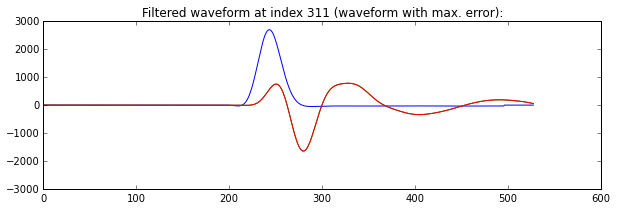

In [3]:
def my_biquad_iir_filter(sos, samples):
    b0, b1, b2, a0, a1, a2 = sos
    assert a0 == 1.0
    
    samples = np.copy(samples)
    z1, z2 = (0.0, 0.0)
    
    for i in range(len(samples)):
        t = samples[i] - a1*z1 - a2*z2
        samples[i] = b0*t + b1*z1 + b2*z2
        z1, z2 = t, z1
    
    return samples

min_sqerr = None
min_sqerr_idx = None

max_sqerr = None
max_sqerr_idx = None

filtered_out = np.zeros((M, N))
for i in range(M):
    filtered_out[i,:] = interp_out[i,:]
    for k in range(iir_sos.shape[0]):
        filtered_out[i,:] = my_biquad_iir_filter(iir_sos[k,:], filtered_out[i,:])
    sqerr = filtered_out[i,:] - REF_FILTERED_SAMPLES[i,:]
    sqerr = sqerr.dot(sqerr)
    
    if min_sqerr is None or sqerr < min_sqerr:
        min_sqerr = sqerr
        min_sqerr_idx = i
    
    if max_sqerr is None or sqerr > max_sqerr:
        max_sqerr = sqerr
        max_sqerr_idx = i

plt.figure(figsize=(10, 3))
plt.title("Min./Max. square error to ref. waveform (at indices %d and %d):" % (min_sqerr_idx, max_sqerr_idx))
plt.plot((filtered_out[min_sqerr_idx,:] - REF_FILTERED_SAMPLES[min_sqerr_idx,:]) ** 2);
plt.plot((filtered_out[max_sqerr_idx,:] - REF_FILTERED_SAMPLES[max_sqerr_idx,:]) ** 2);

plt.figure(figsize=(10,3))
plt.title("Filtered waveform at index %d (waveform with min. error):" % min_sqerr_idx)
plt.plot(interp_out[min_sqerr_idx,:]);
plt.plot(filtered_out[min_sqerr_idx,:]);
plt.plot(REF_FILTERED_SAMPLES[min_sqerr_idx,:]);
plt.ylim(-3000, 3000);

plt.figure(figsize=(10,3))
plt.title("Filtered waveform at index %d (waveform with max. error):" % max_sqerr_idx)
plt.plot(interp_out[max_sqerr_idx,:]);
plt.plot(filtered_out[max_sqerr_idx,:]);
plt.plot(REF_FILTERED_SAMPLES[max_sqerr_idx,:]);
plt.ylim(-3000, 3000);

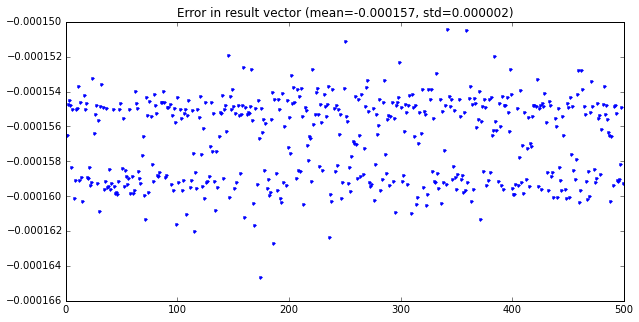

In [4]:
def find_zero_crossings(samples, trig, N):
    zdata = []
    
    for i in range(len(samples)):
        s = samples[i]
        if np.abs(s) > trig:
            break

    for i in range(i, len(samples)-1):
        s1 = samples[i]
        s2 = samples[i+1]
        
        if s2 == 0:
            zdata.append(i)
            zdata.append(s2-s1)
        
        elif (s1 < 0 < s2) or (s1 > 0 > s2):
            zdata.append(i + s1 / (s1 - s2))
            zdata.append(s2-s1)

        if len(zdata) == 2*N:
            break

    assert len(zdata) == 2*N
    return zdata

zd = np.array([find_zero_crossings(filtered_out[i,:], 100, 2) for i in range(M)])

# CDAE statistics data
zavg_diff = np.mean(zd[:, 2] - zd[:, 0])
zavg_del1 = np.mean(zd[:, 1])
zavg_del2 = np.mean(zd[:, 3])

zw = zd[:, 0] * zavg_del1 - zd[:, 2] * zavg_del2
zw = (zw + zavg_diff * 0.5 * (zavg_del1 + zavg_del2)) / (zavg_del1 - zavg_del2)
results = np.vstack([zd[:,0], zd[:,2], (zd[:,0] + zd[:,2]) * 0.5, zw]).T / oversampling
results_err = REF_RESULTS[:,3] - results[:,3]

plt.figure(figsize=(10,5))
plt.title("Error in result vector (mean=%f, std=%f)" % (np.mean(results_err), np.std(results_err)))
plt.plot(results_err, '.');